In [71]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy.stats as stats
import numpy as np
from scipy.stats import chi2_contingency

data = pd.read_csv("Data.csv")

# Re-selecting features for clustering with Label Encoding for categorical variables
selected_features = [
    "Age",
    "MonthlyIncome",
    "MonthlyRate",
    "NumCompaniesWorked",
    "Department",
    "DistanceFromHome",
    "PercentSalaryHike",
    "EducationField",
    "EmployeeNumber",
    "StockOptionLevel",
    "Gender",
    "TotalWorkingYears",
    "HourlyRate",
    "JobLevel",
    "YearsAtCompany",
    "JobRole",
    "YearsInCurrentRole",
    "YearsSinceLastPromotion",
    "MaritalStatus",
]

# Encoding categorical features using LabelEncoder
label_encoders = {}
data_encoded = data[selected_features].copy()

categorical_columns = [
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
]

for col in categorical_columns:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col])
    label_encoders[col] = le

# Standardizing the encoded data for clustering
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)

# Applying KMeans clustering with the chosen optimal number of clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Adding the cluster labels to the data for analysis
data["Cluster"] = clusters

cluster_names = {
    0: "Young, Volatile",
    1: "Mid-Career, Established",
    2: "Senior, Experienced",
    3: "Mid-Career, Undercompensated",
}

# Define a consistent color mapping for clusters
cluster_colors = {
    "Young, Volatile": "#5E81AC",  # Soft Blue
    "Mid-Career, Established": "#A3BE8C",  # Green
    "Senior, Experienced": "#EBCB8B",  # Yellow
    "Mid-Career, Undercompensated": "#D08770"  # Orange
}

# Convert all columns to numeric if possible, excluding non-numeric ones before grouping
numeric_data = data.select_dtypes(include=['number'])

# Summarizing the clustered data by numeric columns only
cluster_summary = numeric_data.groupby("Cluster").mean()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(cluster_summary)
print(cluster_summary)


               Age   DailyRate  DistanceFromHome  Education  EmployeeCount  \
Cluster                                                                      
0        29.650924  780.229979          8.390144   2.624230            1.0   
1        36.490411  809.430137          9.684932   3.005479            1.0   
2        48.081731  813.201923          8.769231   3.062500            1.0   
3        40.287805  817.302439          9.921951   3.097561            1.0   

         EmployeeNumber  EnvironmentSatisfaction  HourlyRate  JobInvolvement  \
Cluster                                                                        
0           1015.866530                 2.696099   66.667351        2.710472   
1           1010.967123                 2.775342   63.764384        2.742466   
2           1017.908654                 2.740385   66.250000        2.687500   
3           1051.456098                 2.695122   66.680488        2.763415   

         JobLevel  JobSatisfaction  MonthlyIncome 

Cluster_Name column successfully mapped. Unique values: ['Mid-Career, Undercompensated' 'Mid-Career, Established'
 'Young, Volatile' 'Senior, Experienced']


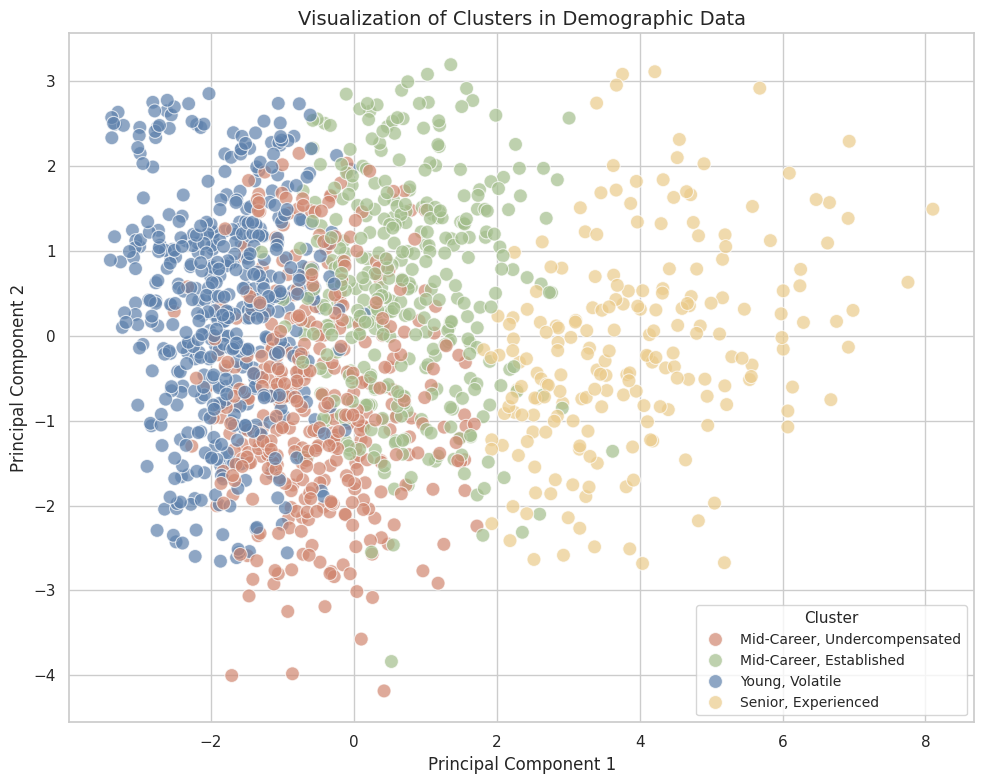

In [72]:
# Ensure that the Cluster column exists and map it to Cluster_Name
if 'Cluster' in data.columns:
    data['Cluster_Name'] = data['Cluster'].map(cluster_names)
else:
    print("Error: 'Cluster' column is missing from the data.")

# Check if Cluster_Name has been mapped correctly
if 'Cluster_Name' not in data.columns:
    print("Error: 'Cluster_Name' column is missing after mapping.")
else:
    print("Cluster_Name column successfully mapped. Unique values:", data['Cluster_Name'].unique())

# Perform PCA for dimensionality reduction to visualize the clusters in 2D space
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_scaled)
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])

if 'Cluster_Name' in data.columns:
    pca_df['Cluster_Name'] = data['Cluster_Name']
else:
    print("Error: Unable to find 'Cluster_Name' in the data.")

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df,
    x='PCA1',
    y='PCA2',
    hue='Cluster_Name',
    palette=cluster_colors,
    s=100,
    alpha=0.7
)
plt.title('Visualization of Clusters in Demographic Data', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True)
plt.legend(title='Cluster', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()


/tmp/ipykernel_1205674/923788603.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_labels, y=attrition_rates, palette=[cluster_colors[name] for name in cluster_labels], ax=ax[1])


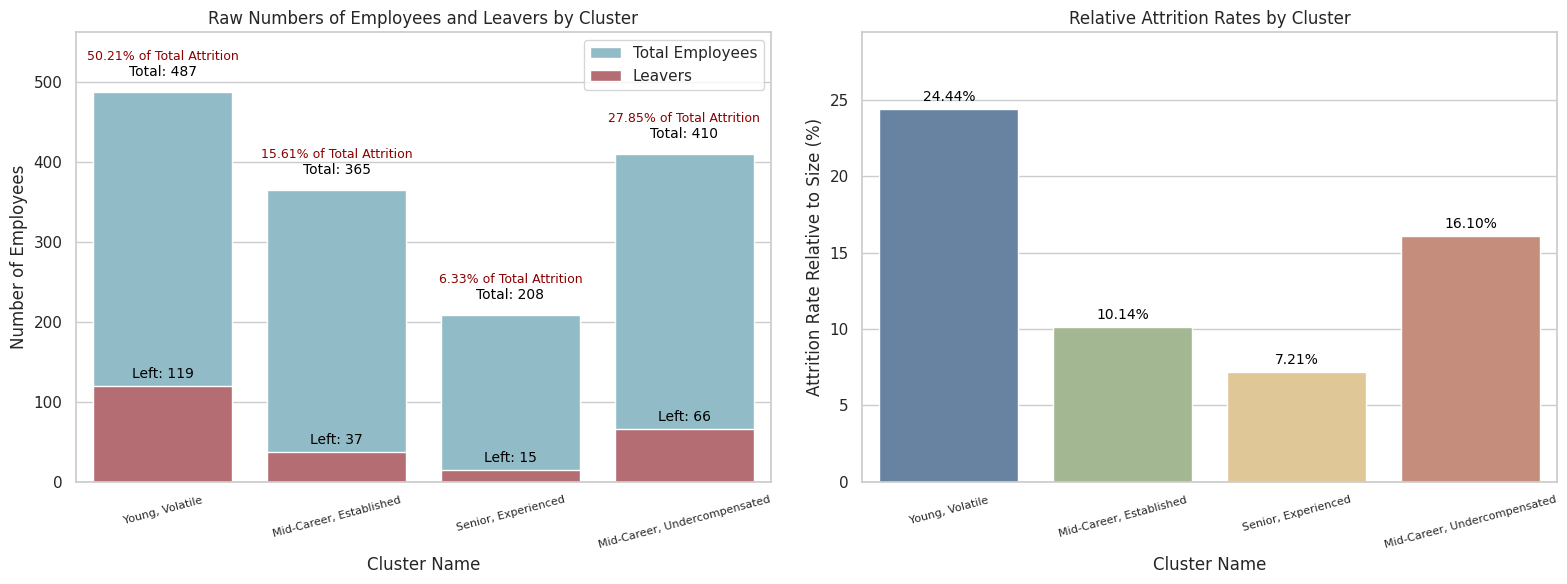

In [73]:
data['Cluster_Name'] = data['Cluster'].map(cluster_names)

data['Attrition'] = data['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

total_employees_by_cluster = data.groupby(['Cluster', 'Cluster_Name']).size()
leavers_by_cluster = data.groupby(['Cluster', 'Cluster_Name'])['Attrition'].sum()
attrition_rate_by_cluster_relative = (leavers_by_cluster / total_employees_by_cluster) * 100

cluster_labels = [name for _, name in total_employees_by_cluster.index]
total_employees = total_employees_by_cluster.values
leavers = leavers_by_cluster.values
attrition_rates = attrition_rate_by_cluster_relative.values

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# First subplot: Raw numbers of employees and leavers using seaborn
sns.barplot(x=cluster_labels, y=total_employees, color='#88C0D0', ax=ax[0], label='Total Employees')
sns.barplot(x=cluster_labels, y=leavers, color='#BF616A', ax=ax[0], label='Leavers')
ax[0].set_title('Raw Numbers of Employees and Leavers by Cluster')
ax[0].set_ylabel('Number of Employees')
ax[0].set_xlabel('Cluster Name')
ax[0].legend()
ax[0].tick_params(axis='x', labelsize=8, rotation=15)
ax[0].set_ylim(0, max(total_employees) + 75)

# Add data labels including total attrition percentage
for i, (total, left) in enumerate(zip(total_employees, leavers)):
    attrition_percent = (left / sum(leavers)) * 100
    ax[0].text(i, total + 40, f'{attrition_percent:.2f}% of Total Attrition', ha='center', fontsize=9, color='darkred')
    ax[0].text(i, total + 20, f'Total: {total}', ha='center', fontsize=10, color='black')
    ax[0].text(i, left + 10, f'Left: {left}', ha='center', fontsize=10, color='black')

# Second subplot: Attrition rates relative to cluster sizes using seaborn
sns.barplot(x=cluster_labels, y=attrition_rates, palette=[cluster_colors[name] for name in cluster_labels], ax=ax[1])
ax[1].set_title('Relative Attrition Rates by Cluster')
ax[1].set_ylabel('Attrition Rate Relative to Size (%)')
ax[1].set_xlabel('Cluster Name')
ax[1].set_ylim(0, max(attrition_rates) + 5)
ax[1].tick_params(axis='x', labelsize=8, rotation=15)

for index, rate in enumerate(attrition_rates):
    ax[1].text(index, rate + 0.5, f'{rate:.2f}%', ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


OverTime values after encoding: [1 0]
BusinessTravel values after encoding: [2 1 0]
Encoded data sample:
    OverTime  BusinessTravel
0         1               2
1         0               1
2         1               2
3         1               1
4         0               2


/home/islam/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


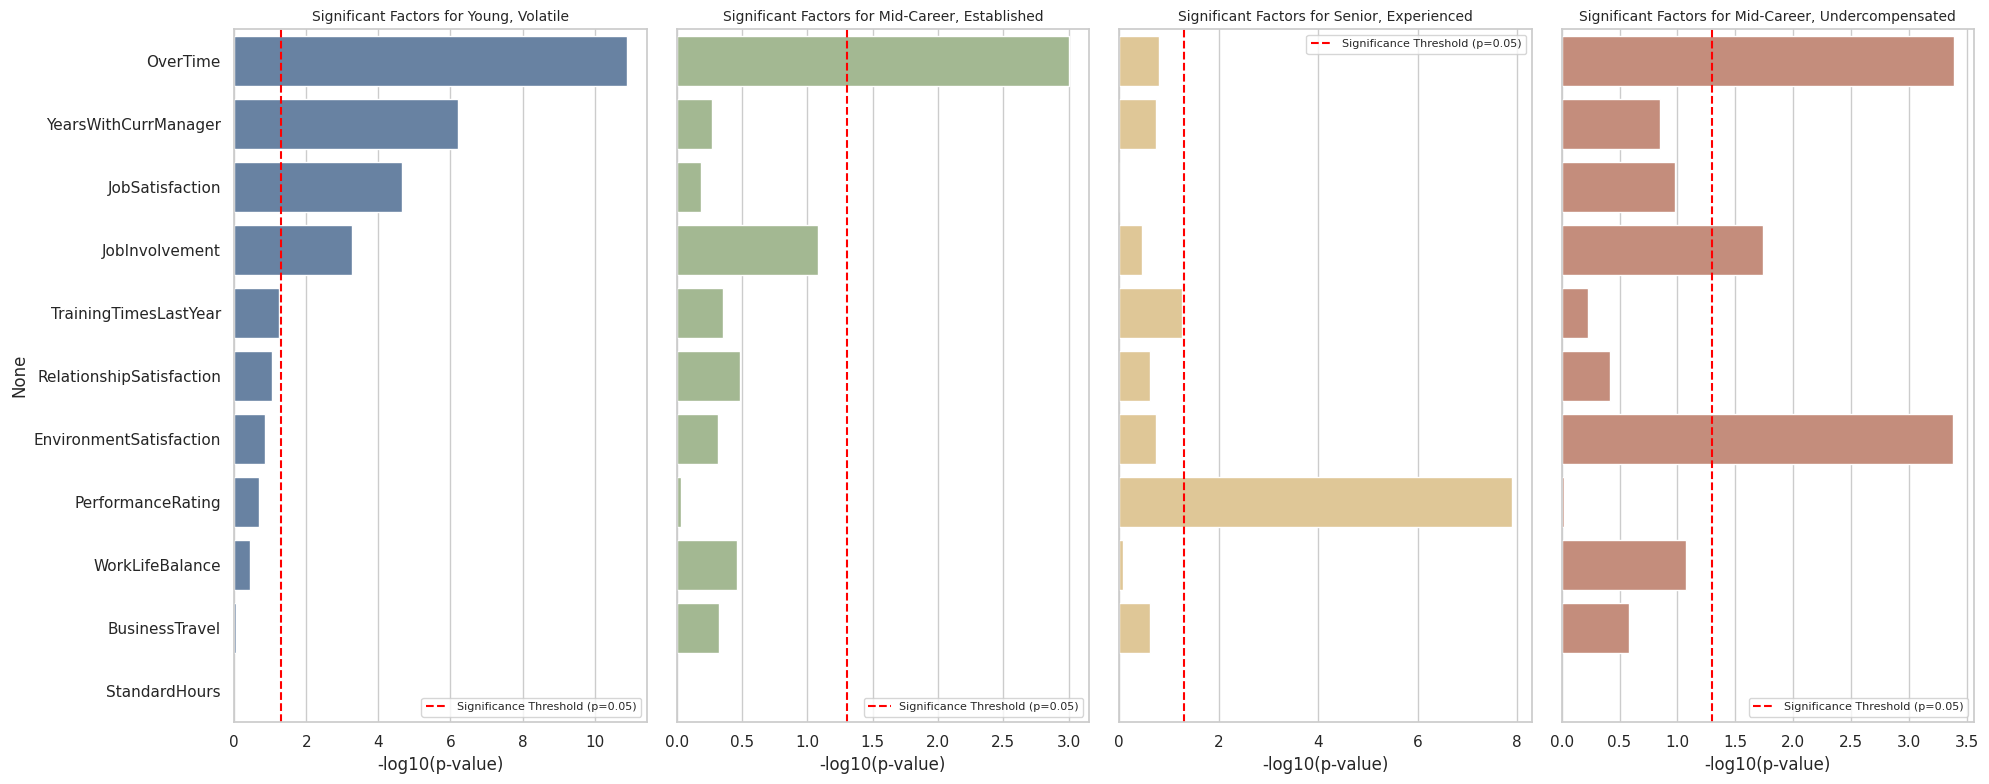

In [74]:
# Define non-demographic features to analyze
non_demo_features = [
    'BusinessTravel', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction',
    'StandardHours', 'EnvironmentSatisfaction', 'TrainingTimesLastYear',
    'JobInvolvement', 'WorkLifeBalance', 'JobSatisfaction', 'YearsWithCurrManager'
]

desired_order = [
    "Young, Volatile",
    "Mid-Career, Established",
    "Senior, Experienced",
    "Mid-Career, Undercompensated",
]

# Initialize LabelEncoder for binary categorical variables
label_encoder = LabelEncoder()

# Encode 'OverTime' and 'BusinessTravel' using LabelEncoder for consistency
if 'OverTime' in data.columns:
    data['OverTime'] = label_encoder.fit_transform(data['OverTime'].astype(str))
    print("OverTime values after encoding:", data['OverTime'].unique())
else:
    print("OverTime column is missing from the data.")

if 'BusinessTravel' in data.columns:
    data['BusinessTravel'] = label_encoder.fit_transform(data['BusinessTravel'].astype(str))
    print("BusinessTravel values after encoding:", data['BusinessTravel'].unique())
else:
    print("BusinessTravel column is missing from the data.")

# Re-encode other categorical variables using pd.get_dummies(), excluding 'OverTime' and 'BusinessTravel'
categorical_features = [feature for feature in non_demo_features if feature not in ['OverTime', 'BusinessTravel']]
data_encoded = pd.get_dummies(data[categorical_features], drop_first=True)

# Add the binary-encoded 'OverTime' and 'BusinessTravel' back to the encoded data
data_encoded['OverTime'] = data['OverTime']
data_encoded['BusinessTravel'] = data['BusinessTravel']

print("Encoded data sample:\n", data_encoded[['OverTime', 'BusinessTravel']].head())

# Ensure all clusters have the same set of columns
full_columns = data_encoded.columns

# Initialize dictionary to store p-values for each cluster
p_values_clusters = {cluster_name: {} for cluster_name in data['Cluster_Name'].unique()}

# Calculate p-values for each cluster and each factor
for cluster in p_values_clusters.keys():
    cluster_data = data[data['Cluster_Name'] == cluster]
    cluster_data_encoded = data_encoded.loc[cluster_data.index].reindex(columns=full_columns, fill_value=0)
    for column in cluster_data_encoded.columns:
        attrition_yes = cluster_data_encoded[cluster_data['Attrition'] == 1][column]
        attrition_no = cluster_data_encoded[cluster_data['Attrition'] == 0][column]
        # Use t-test to find significance
        _, p_value = stats.ttest_ind(attrition_yes, attrition_no, nan_policy='omit', equal_var=False)
        p_values_clusters[cluster][column] = p_value

# Convert p-values into a DataFrame for better visualization
p_values_df = pd.DataFrame(p_values_clusters)

# Rank the most significant factors for each cluster by sorting by p-value
ranked_factors = {cluster: p_values_df[cluster].sort_values() for cluster in p_values_clusters.keys()}

# Ensure clusters are ordered correctly in ranked_factors
ordered_ranked_factors = {cluster: ranked_factors[cluster] for cluster in desired_order}

# Plotting the significant factors and their p-values for each cluster in the desired order
fig, ax = plt.subplots(1, len(ordered_ranked_factors), figsize=(20, 8), sharey=True)

# Define consistent colors for the plots using the cluster mapping
for i, (cluster, ranked) in enumerate(ordered_ranked_factors.items()):
    sns.barplot(
        y=ranked.index,
        x=-np.log10(ranked.values),
        ax=ax[i],
        color=cluster_colors[cluster]
    )
    ax[i].set_title(f'Significant Factors for {cluster}', fontsize=10)
    ax[i].set_xlabel('-log10(p-value)')
    ax[i].axvline(-np.log10(0.05), color='red', linestyle='--', label='Significance Threshold (p=0.05)')
    ax[i].legend(fontsize=8)

plt.tight_layout()
plt.show()


In [75]:
from scipy.stats import pearsonr

# Define function to compute and print correlation for a given feature and cluster data
def compute_correlation(cluster_data, feature):
    correlation, p_value = pearsonr(cluster_data[feature], cluster_data['Attrition'])
    print(f"Correlation between '{feature}' and 'Attrition' in Young, Volatile Employees: {correlation:.4f}")
    print(f"P-value: {p_value:.4e}\n")

# Filter the data for the "Young, Volatile" cluster
young_volatile_data = data[data['Cluster_Name'] == "Young, Volatile"]

# Compute correlations for the specified features
compute_correlation(young_volatile_data, 'OverTime')
compute_correlation(young_volatile_data, 'YearsWithCurrManager')
compute_correlation(young_volatile_data, 'JobSatisfaction')
compute_correlation(young_volatile_data, 'JobInvolvement')

Correlation between 'OverTime' and 'Attrition' in Young, Volatile Employees: 0.3462
P-value: 3.6815e-15

Correlation between 'YearsWithCurrManager' and 'Attrition' in Young, Volatile Employees: -0.2178
P-value: 1.2186e-06

Correlation between 'JobSatisfaction' and 'Attrition' in Young, Volatile Employees: -0.1923
P-value: 1.9252e-05

Correlation between 'JobInvolvement' and 'Attrition' in Young, Volatile Employees: -0.1637
P-value: 2.8702e-04



In [76]:
# Filter the data for the "Mid-Career, Established" cluster
mid_career_established_data = data[data['Cluster_Name'] == "Mid-Career, Established"]

# Compute correlation for Overtime
correlation, p_value = pearsonr(mid_career_established_data['OverTime'], mid_career_established_data['Attrition'])
print(f"Correlation between 'OverTime' and 'Attrition' in Mid-Career, Established Employees: {correlation:.4f}")
print(f"P-value: {p_value:.4e}\n")

Correlation between 'OverTime' and 'Attrition' in Mid-Career, Established Employees: 0.2089
P-value: 5.7613e-05



In [77]:
# Filter the data for the "Senior, Experienced" cluster
senior_experienced_data = data[data['Cluster_Name'] == "Senior, Experienced"]

# Compute correlation for Performance Rating
correlation, p_value = pearsonr(senior_experienced_data['PerformanceRating'], senior_experienced_data['Attrition'])
print(f"Correlation between 'Performance Rating' and 'Attrition' in Senior, Experienced Employees: {correlation:.4f}")
print(f"P-value: {p_value:.4e}\n")


Correlation between 'Performance Rating' and 'Attrition' in Senior, Experienced Employees: -0.1145
P-value: 9.9744e-02



In [78]:
# Filter the data for the "Mid-Career, Undercompensated" cluster
mid_career_Undercompensated_data = data[data['Cluster_Name'] == "Mid-Career, Undercompensated"]

# Compute correlations for the specified features
compute_correlation(mid_career_Undercompensated_data, 'OverTime')
compute_correlation(mid_career_Undercompensated_data, 'JobInvolvement')
compute_correlation(mid_career_Undercompensated_data, 'EnvironmentSatisfaction')

Correlation between 'OverTime' and 'Attrition' in Young, Volatile Employees: 0.1968
P-value: 6.0426e-05

Correlation between 'JobInvolvement' and 'Attrition' in Young, Volatile Employees: -0.1367
P-value: 5.5706e-03

Correlation between 'EnvironmentSatisfaction' and 'Attrition' in Young, Volatile Employees: -0.1899
P-value: 1.0943e-04



Role Representation (Proportions) by Cluster:
Cluster_Name               Young, Volatile  Mid-Career, Established  \
JobRole                                                               
Healthcare Representative         0.024641                 0.093151   
Human Resources                   0.047228                 0.013699   
Laboratory Technician             0.262834                 0.112329   
Manager                           0.000000                 0.013699   
Manufacturing Director            0.049281                 0.147945   
Research Director                 0.002053                 0.041096   
Research Scientist                0.338809                 0.139726   
Sales Executive                   0.143737                 0.410959   
Sales Representative              0.131417                 0.027397   

Cluster_Name               Senior, Experienced  Mid-Career, Undercompensated  
JobRole                                                                       
Healthcare Rep

/tmp/ipykernel_1205674/4140977557.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  role_proportions = role_counts.div(role_counts.sum(axis=0), axis=1).applymap(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)


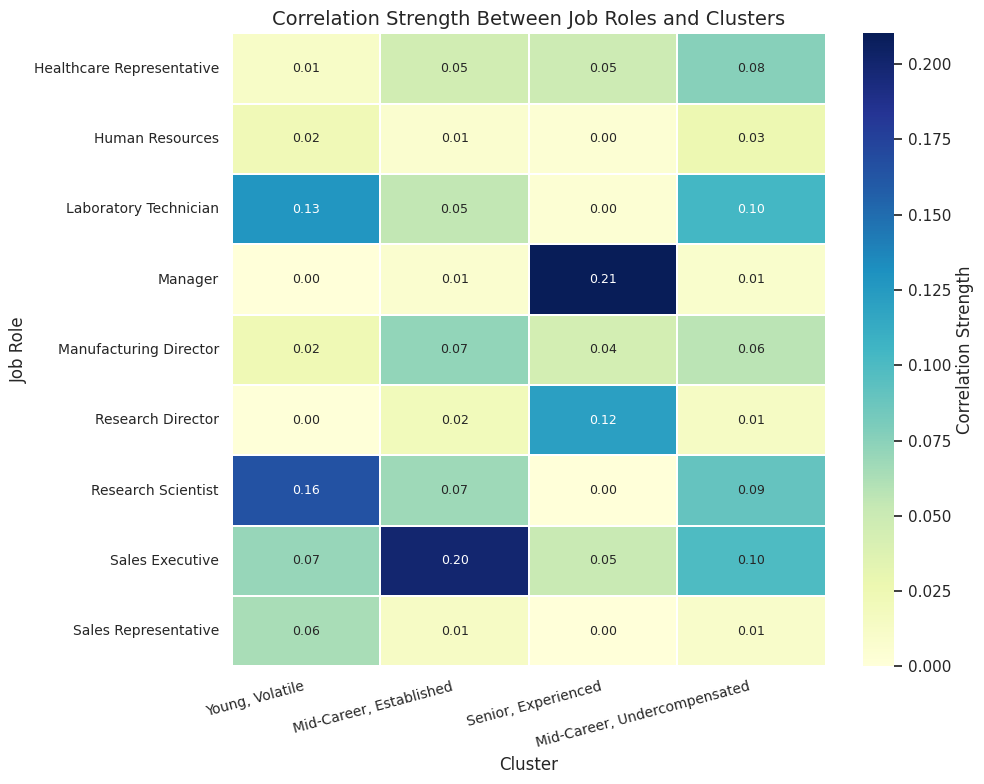

In [79]:
# Calculate Role Representation within each Cluster
role_counts = pd.crosstab(data['JobRole'], data['Cluster_Name'])

desired_order = ["Young, Volatile", "Mid-Career, Established", "Senior, Experienced", "Mid-Career, Undercompensated"]
role_counts = role_counts[desired_order]

role_proportions = role_counts.div(role_counts.sum(axis=0), axis=1).applymap(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
role_percentages = role_counts.div(role_counts.sum(axis=1), axis=0) * 100  # Percentage of each role in each cluster
overall_percentages = (role_counts.T / role_counts.sum(axis=1)).T * 100     # Overall percentage of each role in all clusters

print("Role Representation (Proportions) by Cluster:")
print(role_proportions)
print("\nPercentage of Roles in Each Cluster:")
print(role_percentages)
print("\nOverall Percentage of Each Role Across Clusters:")
print(overall_percentages)

# Chi-square Test for Independence to find significant associations
chi2, p, dof, expected = chi2_contingency(role_counts)
n = role_counts.values.sum()
cramers_v = np.sqrt(chi2 / (n * (min(role_counts.shape) - 1)))

print("\nChi-square Test Results:")
print(f"Chi2 = {chi2:.4f}, p-value = {p:.4e}, Degrees of Freedom = {dof}")
print(f"Cramér's V (Strength of Association) = {cramers_v:.4f}")

# Calculate Correlation Strength for each role and cluster
correlation_strength = role_proportions * cramers_v

print("\nCorrelation Strength Between Job Roles and Clusters:")
print(correlation_strength)

# Identifying Significant Roles per Cluster
threshold = 0.1
significant_roles = correlation_strength[correlation_strength > threshold].stack().reset_index()
significant_roles.columns = ['Job Role', 'Cluster', 'Correlation Strength']

significant_roles['Role Percentage in Cluster'] = significant_roles.apply(
    lambda x: role_percentages.loc[x['Job Role'], x['Cluster']], axis=1
)
significant_roles['Overall Role Percentage'] = significant_roles.apply(
    lambda x: overall_percentages.loc[x['Job Role'], x['Cluster']], axis=1
)

print("\nSignificant Roles by Cluster (Correlation Strength > 0.1):")
print(significant_roles)

# Visualization of the correlation strength between job roles and clusters with smoother aesthetics
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_strength[desired_order],
    annot=True,
    cmap='YlGnBu',
    fmt=".2f",
    cbar=True,
    linewidths=.3,
    linecolor='white',
    annot_kws={"size": 9},
    cbar_kws={'label': 'Correlation Strength'}
)
plt.title('Correlation Strength Between Job Roles and Clusters', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Job Role', fontsize=12)
plt.xticks(rotation=15, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
